# Variational API Quickstart

[**Original article**](https://docs.pymc.io/notebooks/variational_api_quickstart.html)

The variational inference (VI) API in PyMC3 can be use to approximate posterior distributions for Bayesian models.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
import theano

%matplotlib inline
%config InlineBackend.figure_format = "retina"

gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))

sns_blue = "#1F77B4"

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pm.set_tt_rng(RANDOM_SEED)

## Setup

Begin with an example of modeling a mixture model.

In [2]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])

with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

The expectations for this model cannot be computed analytically, but an approximation can be found using MCMC methods (e.g. NUTS).

In [3]:
with model:
    pm.Deterministic("x2", x2)
    pm.Deterministic("sin_x", sin_x)

    trace = pm.sample(50000)

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 50_000 draw iterations (2_000 + 100_000 draws total) took 84 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


We can plot the traces for $x^2$ and $\sin(x)$ and see the clear multi-modality of the model.

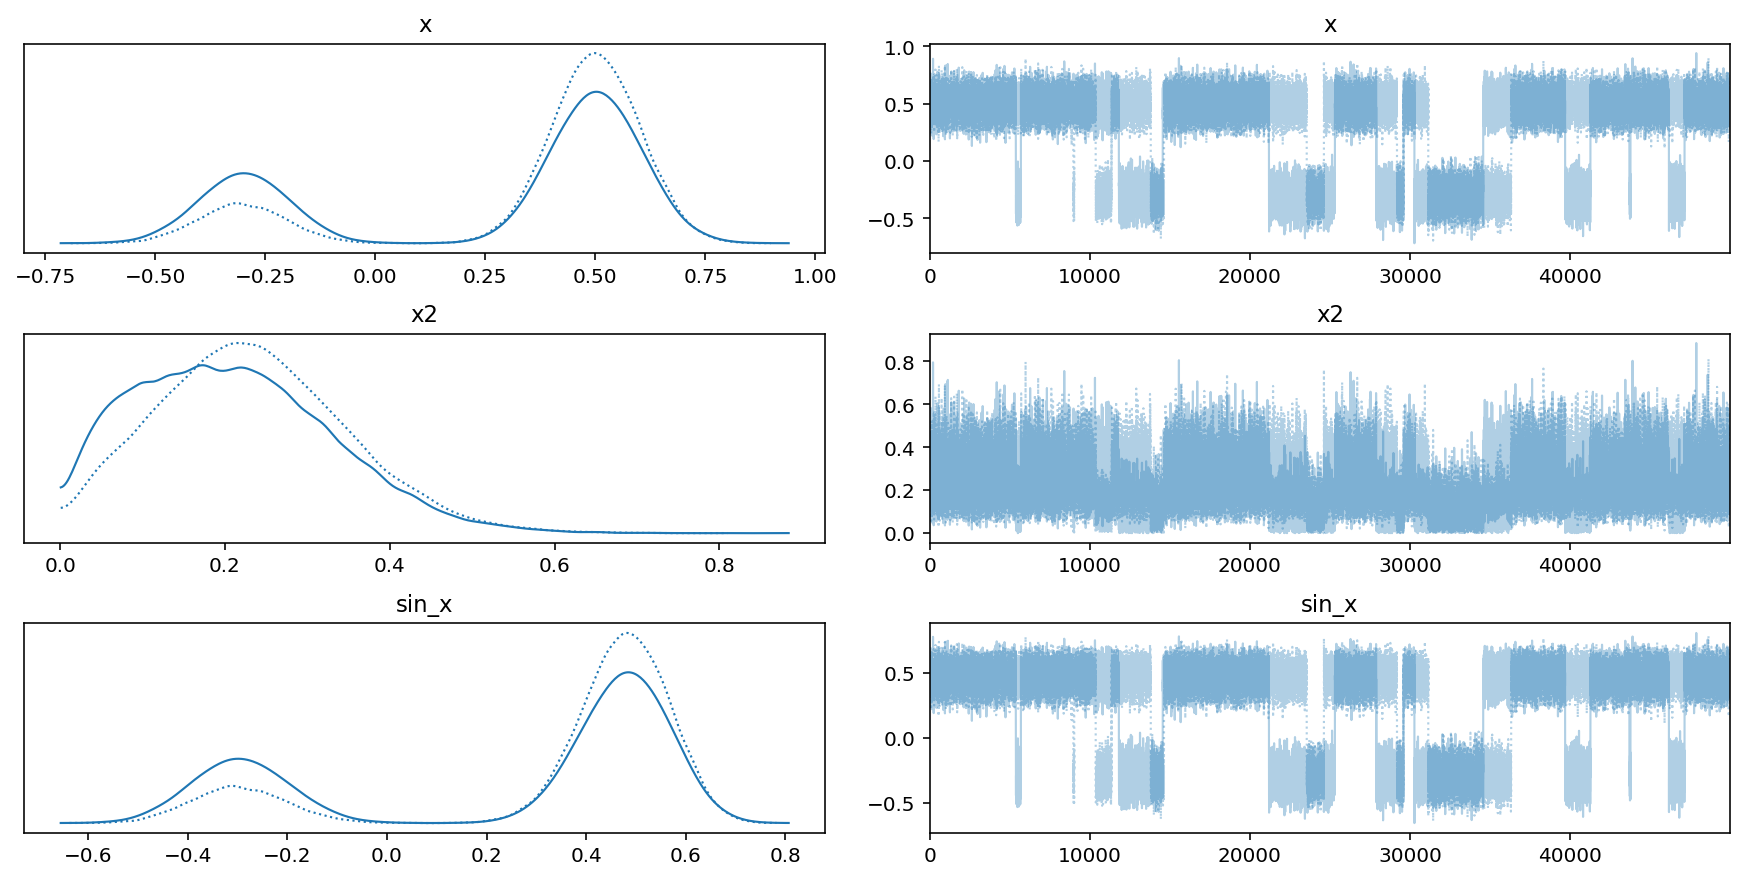

In [4]:
az.plot_trace(az.from_pymc3(trace=trace, model=model));

One drawback of the above approach is that we need to know in advance what we want to see in the trace and wrap it with `pm.Deterministic()`.

The VI API takes an alternate approach: we obtain inference from the model, then calculate expressions based on the model.

We will use the same model as an example.

In [5]:
with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

    mean_field = pm.fit(method="advi")

Finished [100%]: Average Loss = 2.2687


We can see below that ADVI has failed to approximate the multimodel distribution because it uses a Gaussian distribution with a single mode.

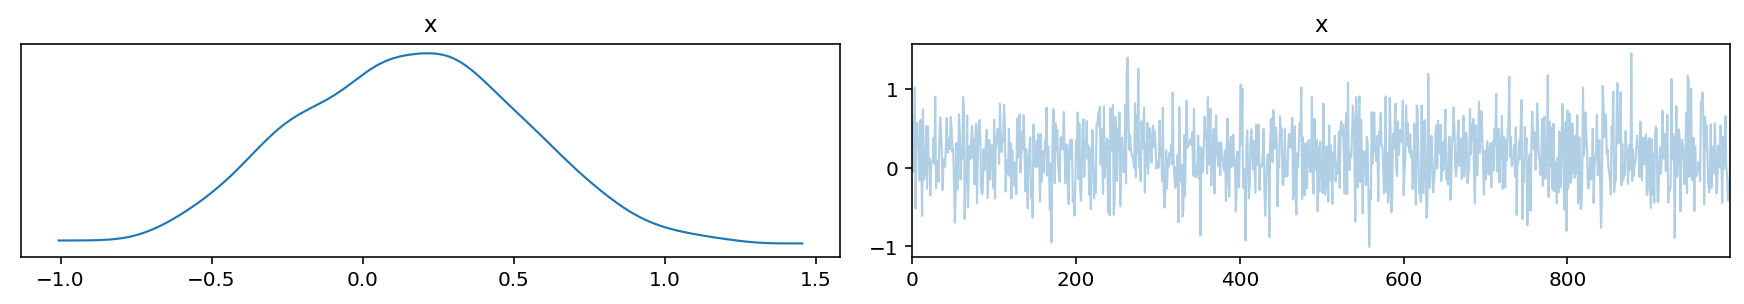

In [6]:
az.plot_trace(az.from_pymc3(trace=mean_field.sample(1000), model=model));

## Checking convergence

We can use the `pm.callbacks.CheckParametersConvergence()` callback to check if the VI converges.

In [7]:
with model:
    mean_field = pm.fit(
        method="advi", callbacks=[pm.callbacks.CheckParametersConvergence()]
    )

Finished [100%]: Average Loss = 2.2763


We can access the inference history in the `.hist` attribute of the `mean_field` object.

In [8]:
def plot_vi_hist(mf: pm.variational.approximations.MeanField) -> gg.ggplot:
    d = pd.DataFrame({"hist": mf.hist, "step": np.arange(len(mf.hist))})
    return (
        gg.ggplot(d, gg.aes(x="step", y="hist"))
        + gg.geom_line(color=sns_blue, alpha=0.8)
        + gg.labs(x="step", y="inference")
    )

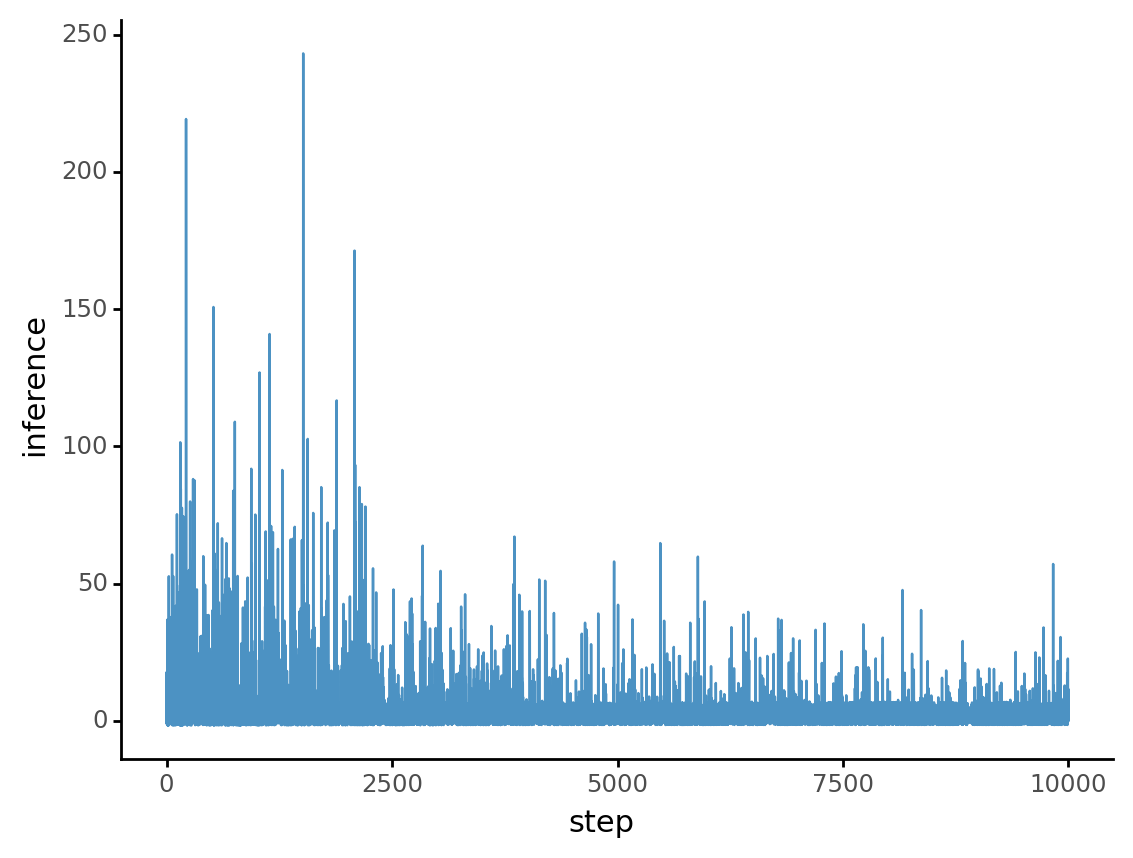

<ggplot: (343893887)>

In [9]:
plot_vi_hist(mean_field)

This is not a good convergence plot, even though we ran many iterations.
It is poor because the mean of the ADVI approximation is close to 0.
Therefore, taking the relative difference (the default method, `diff="relative"`) is unstable for checking convergence.
We can fix this by setting the `diff` parameter of the callback to `"absolute"`.

In [10]:
with model:
    mean_field = pm.fit(
        method="advi",
        callbacks=[pm.callbacks.CheckParametersConvergence(diff="absolute")],
    )

Convergence achieved at 4700
Interrupted at 4,699 [46%]: Average Loss = 4.7996


Now, we can see that convergence is achieved much sooner at 4,700 steps.

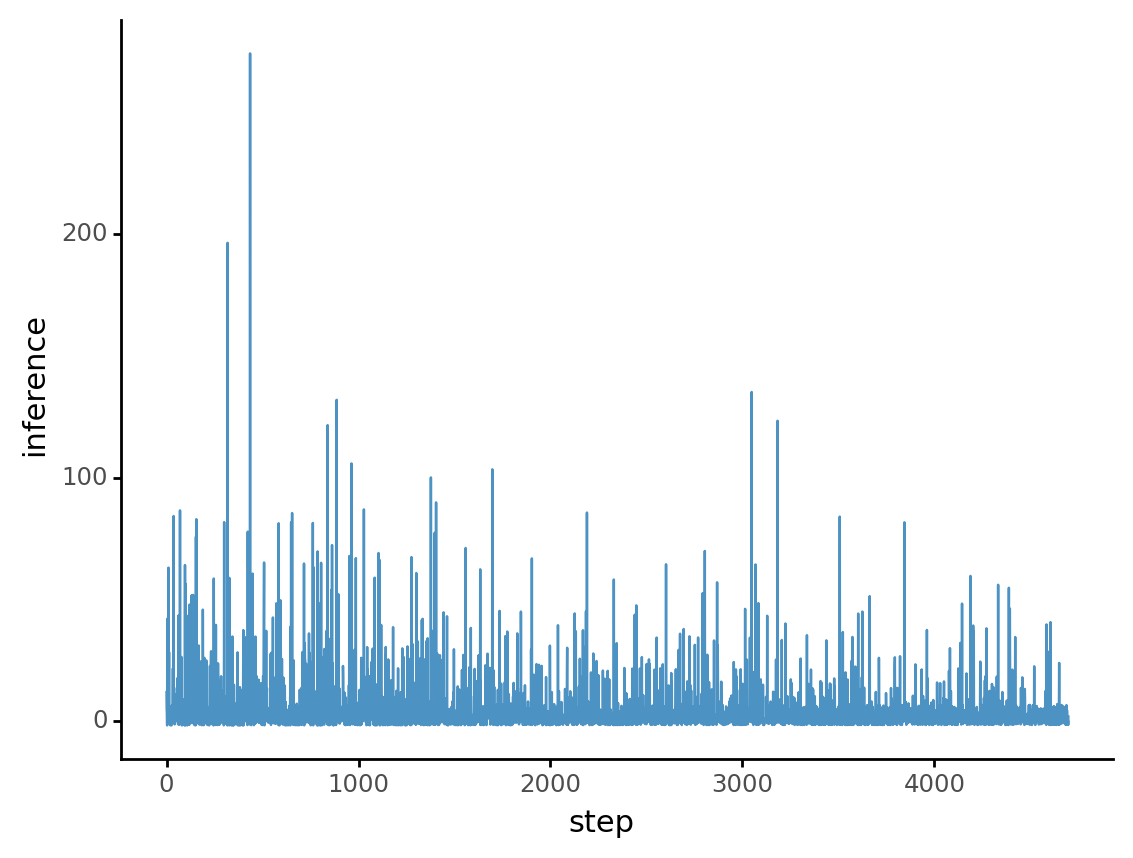

<ggplot: (343598644)>

In [11]:
plot_vi_hist(mean_field)

## Tracking parameters